# Import library

In [1]:
#!pip install scikeras
!pip install --upgrade scikit-learn scikeras tensorflow

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, cross_validate, learning_curve, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor,KerasClassifier
from scipy.stats import randint, uniform


# Load the Dataset

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

# Load the dataset
try:
    df = pd.read_csv('movie_data.csv')
except FileNotFoundError:
    print("Error: movie_data.csv not found. Please ensure the file is in the correct directory.")
    exit()

print(df.shape)
print(df.head(3))

(5043, 15)
   index   director_name  duration      actor_2_name  \
0      0   James Cameron     178.0  Joel David Moore   
1      1  Gore Verbinski     169.0     Orlando Bloom   
2      2      Sam Mendes     148.0      Rory Kinnear   

                            genres     actor_1_name  \
0  Action|Adventure|Fantasy|Sci-Fi      CCH Pounder   
1         Action|Adventure|Fantasy      Johnny Depp   
2        Action|Adventure|Thriller  Christoph Waltz   

                                 movie_title  num_voted_users  \
0                                    Avatar            886204   
1  Pirates of the Caribbean: At World's End            471220   
2                                   Spectre            275868   

       actor_3_name                                    movie_imdb_link  \
0         Wes Studi  http://www.imdb.com/title/tt0499549/?ref_=fn_t...   
1    Jack Davenport  http://www.imdb.com/title/tt0449088/?ref_=fn_t...   
2  Stephanie Sigman  http://www.imdb.com/title/tt2379713/?re

- The dataset contains information about 5,043 movies with 15 columns.




# Data Preprocessing

In [4]:
# Drop irrelevant columns
df_clean = df.drop(columns=[
    'index', 'movie_imdb_link', 'movie_title',
    'actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name'
])

# Classification label
df_clean['is_high_score'] = (df_clean['imdb_score'] >= 7.0).astype(int)

# Separate targets
features = df_clean.drop(columns=['imdb_score', 'is_high_score'])
target_regression = df_clean['imdb_score']
target_classification = df_clean['is_high_score']

# Encode categoricals
categorical_cols = features.select_dtypes(include='object').columns
for col in categorical_cols:
    features[col] = features[col].astype(str)
    features[col] = LabelEncoder().fit_transform(features[col])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Scale features
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_imputed), columns=features.columns)

In this project, I applied several preprocessing steps to clean and prepare the data for deep learning. First, I removed columns that are not useful for learning, such as names of actors, directors, movie titles, and IMDb links, because they do not provide numeric or structured information for training. Next, I created a new column called is_high_score for classification, where movies with an IMDb score of 7.0 or higher were labeled as 1 (high score), and others as 0 (low score). This helped turn the regression target into a classification problem as well. Then, I separated the input features from the target columns. For the features with text (like language and country), I converted them into numbers using label encoding so that the model can process them. I also handled missing values by filling them with the average value in each column, which avoids problems during training. Finally, I scaled all the numeric features using standardization, which makes sure that all values are on a similar scale. This is important for deep learning models, as it helps them learn faster and avoid being biased toward features with larger values. These steps made the data cleaner and more suitable for training accurate and stable models.

# Train Test Splitting

In [5]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_scaled, target_regression, test_size=0.2, random_state=42)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(features_scaled, target_classification, test_size=0.2, random_state=42)

- Splits the regression target and scaled features into 80% training and 20% testing sets.
- Splits the classification target and the same scaled features into 80% training and 20% testing sets.

#  Regression Target Distribution

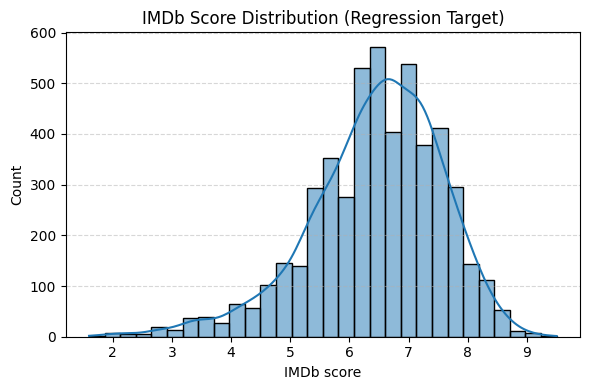

In [6]:
plt.figure(figsize=(6,4))
sns.histplot(target_regression, bins=30, kde=True)
plt.xlabel('IMDb score'); plt.ylabel('Count')
plt.title('IMDb Score Distribution (Regression Target)')
plt.grid(axis='y', linestyle='--', alpha=.5)
plt.tight_layout(); plt.show()

Observation:

The histogram of IMDb scores shows that the regression target is roughly bell-shaped and close to a normal distribution, with most scores falling between about 5.5 and 7.5. The peak is around 6.5 - 7, meaning the majority of movies in the dataset are rated in that range. There are fewer movies with very low scores (below 4) or very high scores (above 8), which means the dataset is center-heavy and has fewer extreme cases. This relatively balanced distribution around the center is good for regression because the model will have enough data in the most common rating range, but it might be slightly less accurate at predicting the rare very low or very high ratings.

# Base Model (Linear Regression) implementation for Regression task

In [7]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
print("Model training for linear regressin completed.")
y_pred_lr = lr.predict(X_test_reg)

Model training for linear regressin completed.


- Creates a Linear Regression model object.
- Trains the model using the training features and regression target.
- Uses the trained model to predict target values for the test set.

# Performance Evaluation for Regression Baseline Model

In [18]:
# Metrics
mae = mean_absolute_error(y_test_reg, y_pred_lr)
mse = mean_squared_error(y_test_reg, y_pred_lr)
r2 = r2_score(y_test_reg, y_pred_lr)
print("Linear Regression:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


Linear Regression:
MSE: 1.0461
MAE: 0.7396
R2: 0.2363


The baseline Linear Regression model had an MSE of 0.7396, an MAE of 1.0461, and an R² score of 0.2363. This means that the predictions were about 1 IMDb score point away from the actual values on average for MAE result. For example, the baseline model might predict something like 7.0 or 9.0 if the true rating is 8.0. And the model could only explain around 23.63% of the variation in the scores. From MSE value (0.74), we can see that predictions deviate quite a bit from actual values. Since it's squared, it penalizes bigger errors more. To conclude, these results show that the model is not very accurate and that a simple linear approach cannot fully capture the patterns in the data.


# Linear Regression  — Residual Diagnostics (histogram)




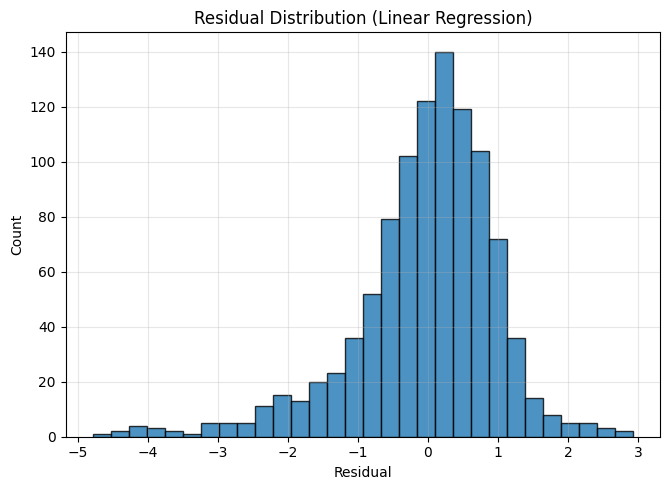

In [9]:
res = y_test_reg - y_pred_lr
plt.figure(figsize=(6.8,5))
plt.hist(res, bins=30, edgecolor='k', alpha=0.8)
plt.xlabel("Residual"); plt.ylabel("Count")
plt.title("Residual Distribution (Linear Regression)")
plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

Observation:

The residual distribution plot for the Linear regression model shows that most residuals are concentrated around zero, forming a roughly bell-shaped and symmetric curve. This indicates that the model's prediction errors are generally small and balanced between overestimation and underestimation. The high peak near zero suggests that for many predictions, the model was very close to the actual IMDb score. However, there are some residuals extending further out on both sides, especially on the negative side, which represent larger errors or outliers. Overall, the distribution suggests the model performs well without major systematic bias, but there are a few cases where prediction errors are relatively large.

# Deep Learning Model (MLP Regression) implementation

In [10]:
# Define model builder for KerasRegressor
def build_model_regression(hidden1=64, hidden2=32, learning_rate=0.001):

  model = Sequential([
      Input(shape=(X_train_reg.shape[1],)),
      Dense(hidden1, activation='relu'),
      Dense(hidden2, activation='relu'),
      Dense(1)  # Output layer for regression
  ])

  model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mae'])
  return model

- Define a function to build a deep learning regression model.
- It includes:
  - Starts a new sequential model.
  - Adds an input layer. The shape matches the number of features in the training data.
  - Adds the first hidden layer with 64 neurons (by default) and ReLU activation.
  - Adds the second hidden layer with 32 neurons (by default) and ReLU activation.
  - Adds the output layer with 1 neuron for regression.
  - Compiles the model. It uses the Adam optimizer, mean squared error for loss, and mean absolute error as an extra metric.

In [11]:
# Wrap it for use with sklearn
mlp_reg = build_model_regression()

history_mlp_reg = mlp_reg.fit(X_train_reg, y_train_reg, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
y_pred_mlp_reg = mlp_reg.predict(X_test_reg).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


- Builds the model using default settings.
- Trains the model using the training data.
- 20% of the data is used for validation.
- The model trains for 50 rounds (epochs), using 32 samples at a time (batch size).
- Uses the trained model to make predictions on the test set and then outputs convert to a 1D array.


# Performance Evaluation for Regression DNN model

In [12]:
mse_mlp_reg = mean_squared_error(y_test_reg, y_pred_mlp_reg)
mae_mlp_reg = mean_absolute_error(y_test_reg, y_pred_mlp_reg)
r2_mlp_reg = r2_score(y_test_reg, y_pred_mlp_reg)
print("MLP Regression:")
print(f"MSE: {mse_mlp_reg:.4f}")
print(f"MAE: {mae_mlp_reg:.4f}")
print(f"R2: {r2_mlp_reg:.4f}")


MLP Regression:
MSE: 0.9031
MAE: 0.6911
R2: 0.3408


The MLP regression model had an MSE of 0.9031, an MAE of 0.6911, and an R2 score of 0.3408. This means that, on average, the predictions were about 0.69 IMDb score points away from the actual values, which is an improvement compared to the baseline linear regression model's error. The R2 value shows that the model could explain around 34% of the variation in IMDb scores, which is higher than the baseline and suggests that the MLP was able to capture more of the patterns in the data. While the MSE appears higher than in the baseline, the lower MAE indicates that the MLP generally made smaller absolute errors, showing better accuracy in most predictions. These results suggest that the MLP handled nonlinear relationships better than the linear model, leading to more reliable predictions overall.

# Convergence Plot showing training and validation losses over epochs in Regression Task

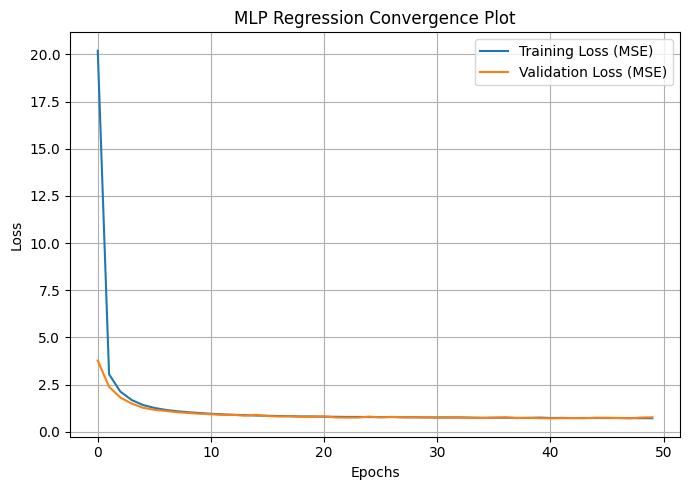

In [13]:
plt.figure(figsize=(7, 5))
plt.plot(history_mlp_reg.history['loss'], label='Training Loss (MSE)')
plt.plot(history_mlp_reg.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Regression Convergence Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Convergence Plot Observations:

During training of the MLP Regression (DNN) model, I monitored both training and validation loss using a validation split. The loss dropped quickly in the first few epochs and then stayed stable, showing that the model learned well without severe overfitting. The validation loss remained close to the training loss throughout the training process. There were no signs of unstable training or major convergence problems. Using the Adam optimizer helped the model train smoothly.

# Hyperparameter Tuning For MLP Regression Model with Random Search

In [15]:
# early stopping implementation
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Wrap model with scikeras KerasRegressor and expose model parameters
reg_model = KerasRegressor(
    model=build_model_regression,
    hidden1=64, hidden2=32, learning_rate=0.001,
    batch_size=32, epochs=50,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# --- Random Search (faster, fewer combinations) ---
param_dist = {
    'hidden1': randint(32, 128), # random number of hidden neurons for first hidden layer
    'hidden2': randint(16, 64), # randon number of hidden neurons for second hidden layer
    'learning_rate': uniform(1e-4, 1e-2), #any value between 0.0001 and about 0.01 could be chosen
    'batch_size': [16, 32, 64], #pick randomly out of 3 options
    'epochs': [30, 50] # epochs will be either 30 or 50
}

random = RandomizedSearchCV(estimator=reg_model, param_distributions=param_dist, n_iter=10, cv=2, scoring='neg_mean_squared_error', random_state=42)
random_result = random.fit(X_train_reg, y_train_reg)

# --- Show best params from Random Search ---
print("Best Random Params:", random_result.best_params_)
print("Best Random MSE: {:.4f}".format(-random_result.best_score_))

Best Random Params: {'batch_size': 16, 'epochs': 30, 'hidden1': 114, 'hidden2': 38, 'learning_rate': np.float64(0.0006808361216819947)}
Best Random MSE: 0.8209


For hyperparameter tuning, i implemented Randon Search for regression. Random search picks random combinations of hyperparameters from specified ranges and evaluates each one. In the implemented code, early stopping was used to halt training when validation loss stopped improving, preventing overfitting and saving time. The Keras regression model was wrapped with KerasRegressor so its hyperparameters could be exposed to scikit-learn's tuning methods. The search space included different numbers of neurons for the first and second hidden layers, a continuous range for learning rate, and fixed options for batch size and epochs. RandomizedSearchCV then tested 10 random parameter sets using 2-fold cross-validation and evaluated them using negative MSE.

The best configuration is a batch size of 16, 30 epochs, 114 neurons in the first hidden layer, 38 in the second, and a learning rate of about 0.00068. This setup achieved the lowest mean cross-validation MSE of 0.8209, indicating better performance than untuned models. The results suggest that a moderately wide first layer, a smaller second layer, and a relatively low learning rate, combined with early stopping, helped the model converge effectively while keeping errors low.

# Evaluate Best Model with K-Fold Cross-Validation For MLP Regression Model

In [16]:
# K-Fold Cross-Validation using best model
# -----------------------------------------------
# Use best hyperparameters from Grid Search
best_model_reg = KerasRegressor(
  model=build_model_regression,
  hidden1=random_result.best_params_['hidden1'],
  hidden2=random_result.best_params_['hidden2'],
  learning_rate=random_result.best_params_['learning_rate'],
  epochs=random_result.best_params_['epochs'],
  batch_size=random_result.best_params_['batch_size'],
  verbose=0
)

# Define 5-fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-validation with multiple scoring metrics
cv = cross_validate(
    best_model_reg, X_train_reg, y_train_reg,
    cv=kfold, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2')
)

# Extract and report results
mse_folds = -cv['test_neg_mean_squared_error']
mae_folds = -cv['test_neg_mean_absolute_error']
r2_folds = cv['test_r2']

mean_mse_tune = np.mean(mse_folds)
mean_mae_tune = np.mean(mae_folds)
mean_r2_tune = np.mean(r2_folds)

# Report
print("\nK-Fold CV Results (5 folds):")
print(f"Mean MSE: { mean_mse_tune:.4f}, Standard deviation: {np.std(mse_folds):.4f}")
print(f"Mean MAE: {mean_mae_tune:.4f}, Standard deviation: {np.std(mae_folds):.4f}")
print(f"Mean R2: {mean_r2_tune:.4f}, Standard deviation: {np.std(r2_folds):.4f}")


K-Fold CV Results (5 folds):
Mean MSE: 0.8074, Standard deviation: 0.0564
Mean MAE: 0.6794, Standard deviation: 0.0229
Mean R2: 0.3486, Standard deviation: 0.0333


K-fold cross-validation was performed using the best hyperparameters obtained from the random search to evaluate the MLP regression model's performance more reliably. In this method, the training data was split into five equal parts, and the model was trained and tested five times, each time using a different fold as the test set and the remaining folds for training.

The results showed a mean MSE of 0.8074 with a standard deviation of 0.0564, and a mean MAE of 0.6794 with a standard deviation of 0.0229. The mean R² score was 0.3486 with a standard deviation of 0.0333. These results indicate that, on average, the model's predictions deviated by about 0.68 IMDb score points from the actual values, and the low standard deviations suggest the model's performance was consistent across different folds. This confirms that the tuned MLP regression model is stable and generalizes well to unseen data.

# Performance Comparison between DNN models and Baseline model For Regression

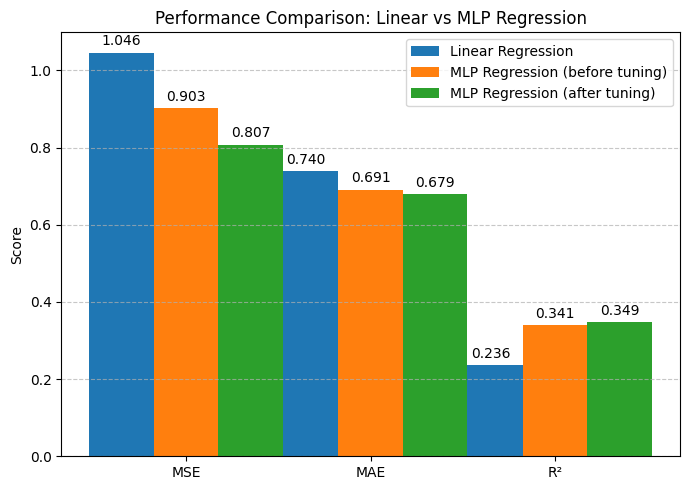

In [17]:
# Metrics from your models
metrics = ['MSE', 'MAE', 'R²']
linear_scores = [mse, mae, r2]   # Linear Regression results
mlp_scores    = [mse_mlp_reg, mae_mlp_reg, r2_mlp_reg]   # MLP Regression (before tuning and cv) results
mlp_scores_tune = [mean_mse_tune, mean_mae_tune, mean_r2_tune] # MLP Regression after tune

x = np.arange(len(metrics))  # metric positions
width = 0.35                  # bar width

fig, ax = plt.subplots(figsize=(7,5))

# Create bars for the three models (Linear, MLP, and Tuned MLP)
bars1 = ax.bar(x - width, linear_scores, width, label='Linear Regression')
bars2 = ax.bar(x, mlp_scores, width, label='MLP Regression (before tuning)')
bars3 = ax.bar(x + width, mlp_scores_tune, width, label='MLP Regression (after tuning)')

# Add labels and formatting
ax.set_ylabel('Score')
ax.set_title('Performance Comparison: Linear vs MLP Regression')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

The comparison shows that the MLP Regression model outperformed Linear Regression in all evaluation metrics. After hyperparameter tuning, the MLP achieved the lowest MSE (0.807) and MAE (0.679), along with the highest R² score (0.349). This indicates that the tuned MLP made smaller prediction errors and explained more variance in the target variable than both Linear Regression and the untuned MLP. The reduction in MSE after tuning was the most notable improvement, demonstrating the benefit of selecting optimal parameters for the model.

Although the gains in MAE and R² after tuning were relatively small, they still reflect a consistent performance improvement. The results suggest that the tuned MLP is better suited for capturing the underlying patterns in the data compared to Linear Regression, which is limited to linear relationships. While tuning significantly reduced error, the gains in MAE and R² were modest which suggest that further improvements may require additional tuning or feature engineering.

# Classification Class Proportion (Pie Chart)

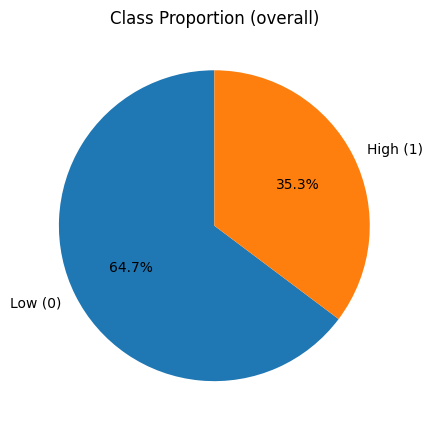

In [19]:
counts = df_clean['is_high_score'].value_counts().sort_index()
plt.figure(figsize=(4.5,4.5))
plt.pie(counts, labels=['Low (0)','High (1)'], autopct='%1.1f%%', startangle=90)
plt.title('Class Proportion (overall)')
plt.tight_layout(); plt.show()

Observations:

The pie chart shows the overall class distribution for the classification label is_high_score. About 64.7% of the movies are labeled as Low (0), meaning their IMDb score is below 7.0, while 35.3% are labeled as High (1), meaning their IMDb score is 7.0 or above. This indicates that the dataset is moderately imbalanced, with significantly more low-score movies than high-score ones. While this imbalance is not extreme, it could still influence model training, potentially making the model more biased toward predicting the majority class.

# Base Model (Logistic Regression) implementation for Classification

In [33]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_clf, y_train_clf)
print("Model training for logistic regressin completed.")

y_pred_log = log_model.predict(X_test_clf)

Model training for logistic regressin completed.


*   Creates a logistic regression model, increasing the maximum iterations to 1000 so the solver has enough time to converge
*   Trains the model using the prepared training features (X_train_clf) and their corresponding class labels (y_train_clf)
*   Uses the trained model to predict the class labels


# Evaluation Functions Implementation

In [34]:
# Evaluation function
def print_metrics(name, y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  print(f"\n{name} Results")
  print(f"Accuracy : {acc:.2%}")
  print(f"Precision: {prec:.2%}")
  print(f"Recall   : {rec:.2%}")
  print(f"F1 Score : {f1:.2%}")

  # Return the metrics for further use (e.g., comparison)
  return acc, prec, rec, f1

# Function to plot heatmap
def plot_confusion_heatmap(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Low', 'Predicted High'],
                yticklabels=['Actual Low', 'Actual High'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Performance Evaluation for Classification Baseline Model


Logistic Regression Results
Accuracy : 75.62%
Precision: 73.28%
Recall   : 50.14%
F1 Score : 59.54%


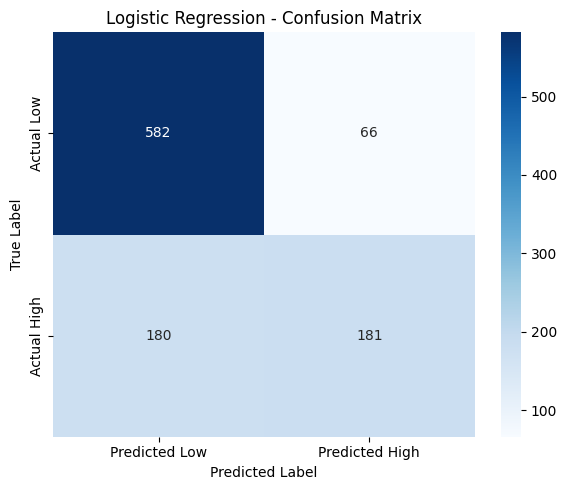

In [35]:
# Print metrics
lr_scores = print_metrics("Logistic Regression", y_test_clf, y_pred_log)
cm_log = confusion_matrix(y_test_clf, y_pred_log)

# Plot heatmaps
plot_confusion_heatmap(cm_log, "Logistic Regression - Confusion Matrix")

The baseline logistic regression model achieved an accuracy of 75.62%, meaning it correctly predicted the class label for about three out of every four movies. The precision of 73.28% shows that when the model predicted a movie as high-score, it was correct about 73% of the time. However, the recall was lower at 50.14%, meaning the model only identified about half of the actual high-score movies. The F1 score, which balances precision and recall, was 59.54%, indicating moderate overall performance. These results suggest that while the model is fairly good at making correct positive predictions, it misses many high-score movies.

# Learnign Curve - Logistic Regression

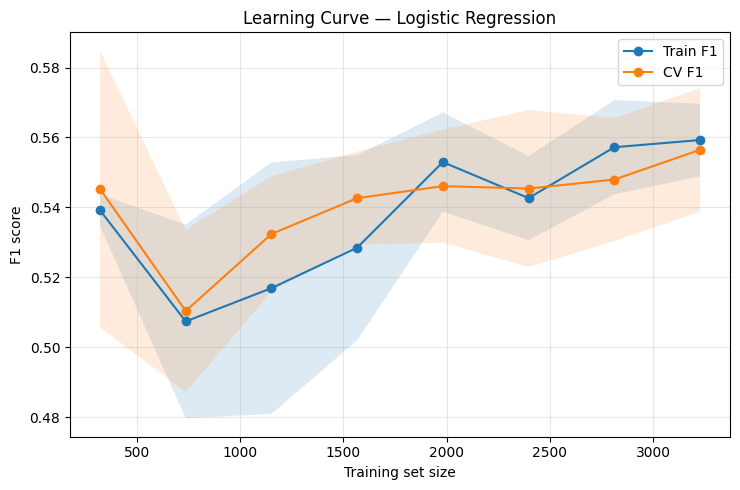

In [36]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=log_model, X=X_train_clf, y=y_train_clf,
    cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=1
)

plt.figure(figsize=(7.5,5))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train F1')
plt.plot(train_sizes, val_scores.mean(axis=1),   marker='o', label='CV F1')
plt.fill_between(train_sizes,
                 train_scores.mean(axis=1)-train_scores.std(axis=1),
                 train_scores.mean(axis=1)+train_scores.std(axis=1), alpha=.15)
plt.fill_between(train_sizes,
                 val_scores.mean(axis=1)-val_scores.std(axis=1),
                 val_scores.mean(axis=1)+val_scores.std(axis=1), alpha=.15)
plt.xlabel("Training set size"); plt.ylabel("F1 score")
plt.title("Learning Curve — Logistic Regression")
plt.legend(); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

Observations:

The learning curve for the Logistic Regression model shows how the F1 score changes as the training set size increases for both the training and cross-validation (CV) sets. At smaller training sizes, the train and CV F1 scores are close, indicating no major overfitting. Initially, both scores drop slightly as more data is added, which is expected as the model shifts from fitting small-sample patterns to learning more general trends. As the training size increases further, both scores gradually improve and stabilize around 0.55–0.56, with a small and consistent gap between them. The shaded regions, representing variability, show some fluctuations but remain relatively narrow. Overall, the plot suggests that the Logistic Regression model generalizes well, benefits from more data, and maintains stable performance without significant overfitting or underfitting.

# Deep Learning Model (MLP Classification) implementation

In [37]:
def build_model_classification(hidden1=64, hidden2=32, learning_rate=0.001, input_dim=None):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(hidden1, activation='relu'),
        Dense(hidden2, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

- Define a function to build a deep learning classification model.
- It includes:
  - Starts a new sequential model.
  - Adds an input layer. The shape matches the number of features in the training data (input_dim).
  - Adds the first hidden layer with hidden1 neurons (64 by default) and ReLU activation.
  - Adds the second hidden layer with hidden2 neurons (32 by default) and ReLU activation.
  - Adds the output layer with 1 neuron and sigmoid activation for binary classification.
  - Compiles the model. It uses the Adam optimizer with the given learning rate, binary crossentropy for loss, and accuracy as the evaluation metric.

In [38]:
# Create the model manually
input_dim = X_train_clf.shape[1]
mlp_cls = build_model_classification(input_dim=input_dim)


history_cls = mlp_cls.fit(X_train_clf, y_train_clf, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
y_pred_mlp_cls = (mlp_cls.predict(X_test_clf).flatten() > 0.5).astype(int)

print("Model training for MLP Classification completed.")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Model training for MLP Classification completed.


- Builds the MLP classification model using the build_model_classification function with the number of input features from the training data.
- Trains the model using the training data.
- 20% of the training data is used for validation during training.
- The model trains for 50 rounds (epochs), using 32 samples at a time (batch size).
- Uses the trained model to make predictions on the test set, flattens the output, and converts predicted probabilities into binary class labels (0 or 1) based on a threshold of 0.5.

# Performance Evaluation for Classification MLP Model


MLP Classification Results
Accuracy : 78.20%
Precision: 73.27%
Recall   : 61.50%
F1 Score : 66.87%


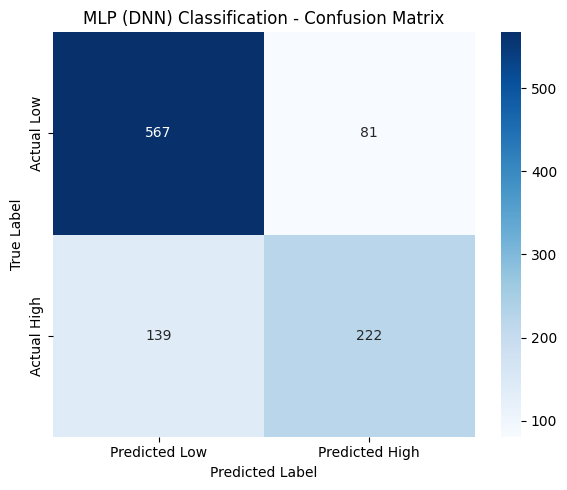

In [39]:
# Print metrics
mlp_scores = print_metrics("MLP Classification", y_test_clf, y_pred_mlp_cls)

cm_mlp_cls = confusion_matrix(y_test_clf, y_pred_mlp_cls)
# Plot heatmaps
plot_confusion_heatmap(cm_mlp_cls, "MLP (DNN) Classification - Confusion Matrix")

The MLP classification model achieved an accuracy of 78.20%, meaning it correctly predicted the class for more than three out of every four movies. The precision of 73.27% indicates that when the model predicted a movie as high-score, it was correct about 73% of the time. The recall was 61.50%, showing that it successfully identified over 61% of all actual high-score movies. The F1 score, which balances precision and recall, was 66.87%, reflecting a reasonable trade-off between correctly predicting high-score movies and finding as many of them as possible.

From the confusion matrix, the model correctly classified 567 low-score movies and 222 high-score movies. However, it misclassified 139 high-score movies as low-score (false negatives) and 81 low-score movies as high-score (false positives). These results indicate the model performs well at detecting low-score movies, but a notable number of high-score movies are still missed, which impacts recall.

# Convergence Plot showing training and validation losses over epochs in Classification

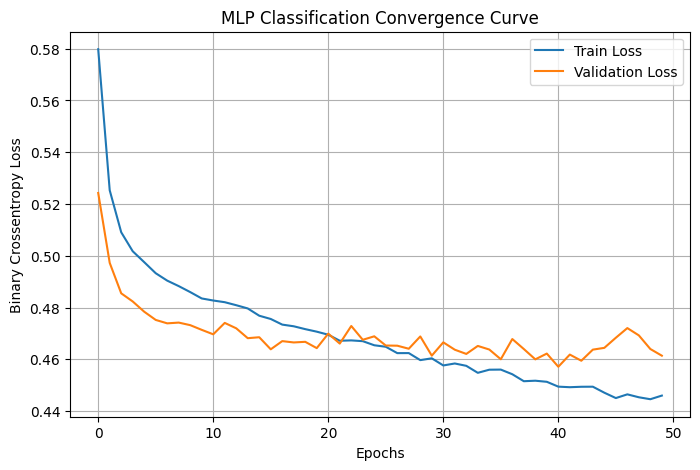

In [40]:
# Plot convergence
plt.figure(figsize=(8, 5))
plt.plot(history_cls.history['loss'], label='Train Loss')
plt.plot(history_cls.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('MLP Classification Convergence Curve')
plt.legend()
plt.grid(True)
plt.show()

The convergence plot for the MLP classification model shows that both the training loss and validation loss decrease steadily over the epochs, indicating that the model is learning effectively. In the early epochs, the losses drop quickly, showing rapid improvement in performance. After around 20 epochs, the rate of decrease slows, and both curves begin to flatten, suggesting that the model is approaching convergence. The validation loss closely follows the training loss throughout, with no significant divergence, which indicates that the model is not overfitting and generalizes well to unseen data. The small fluctuations in validation loss are normal and expected in neural network training.

# Classification — ROC & PR curves (Logistic vs MLP) on same axes

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


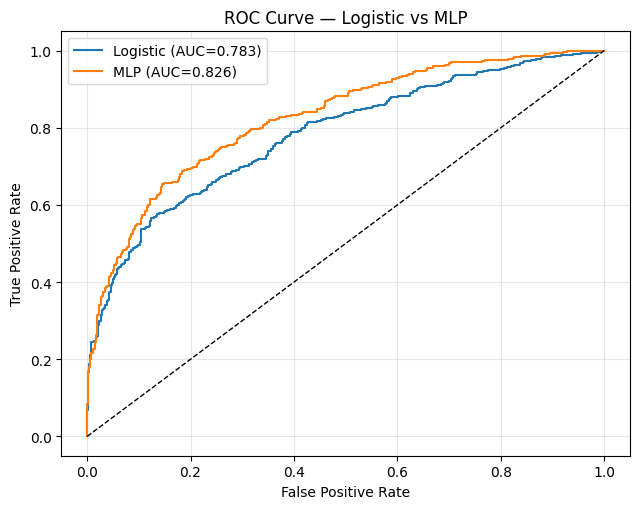

In [41]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Probabilities
proba_lr  = log_model.predict_proba(X_test_clf)[:,1]
proba_mlp = mlp_cls.predict(X_test_clf).ravel()  # sigmoid outputs

# ROC
fpr_lr,  tpr_lr,  _ = roc_curve(y_test_clf, proba_lr)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_clf, proba_mlp)
auc_lr  = auc(fpr_lr, tpr_lr)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(6.5,5.2))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})")
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC={auc_mlp:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic vs MLP")
plt.legend(); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()



Observations:
The ROC curve compares the classification performance of the Logistic Regression model and the MLP model. The MLP curve lies above the Logistic curve for most of the plot, indicating better overall performance. The AUC (Area Under the Curve) score for MLP is 0.830, higher than Logistic Regression's 0.783, meaning the MLP model has a stronger ability to distinguish between the positive and negative classes. Both models perform much better than random guessing (the diagonal dashed line), but the gap in AUC shows that MLP captures more complex patterns in the data, leading to improved classification capability compared to the simpler Logistic Regression baseline.

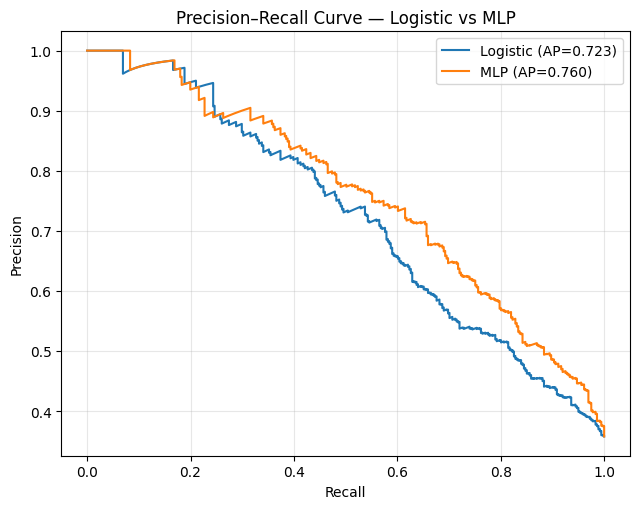

In [42]:
# Precision–Recall
prec_lr, rec_lr, _   = precision_recall_curve(y_test_clf, proba_lr)
prec_mlp, rec_mlp,_  = precision_recall_curve(y_test_clf, proba_mlp)
ap_lr  = average_precision_score(y_test_clf, proba_lr)
ap_mlp = average_precision_score(y_test_clf, proba_mlp)

plt.figure(figsize=(6.5,5.2))
plt.plot(rec_lr, prec_lr, label=f"Logistic (AP={ap_lr:.3f})")
plt.plot(rec_mlp, prec_mlp, label=f"MLP (AP={ap_mlp:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Logistic vs MLP")
plt.legend(); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

Observations:

The Precision–Recall curve compares the performance of the Logistic Regression and MLP models in distinguishing between the positive and negative classes. The MLP curve consistently stays above the Logistic curve for most recall values, indicating that MLP generally achieves higher precision at the same recall levels. The Average Precision (AP) score for MLP is 0.763, higher than Logistic Regression’s 0.723, meaning MLP is better at maintaining a balance between precision and recall, especially in handling the positive class. Both models show a gradual decline in precision as recall increases, which is expected, but MLP retains better performance throughout, confirming its advantage in classification quality over the baseline logistic regression model.


# Performance Comparison between DNN model and baseline model For Classification

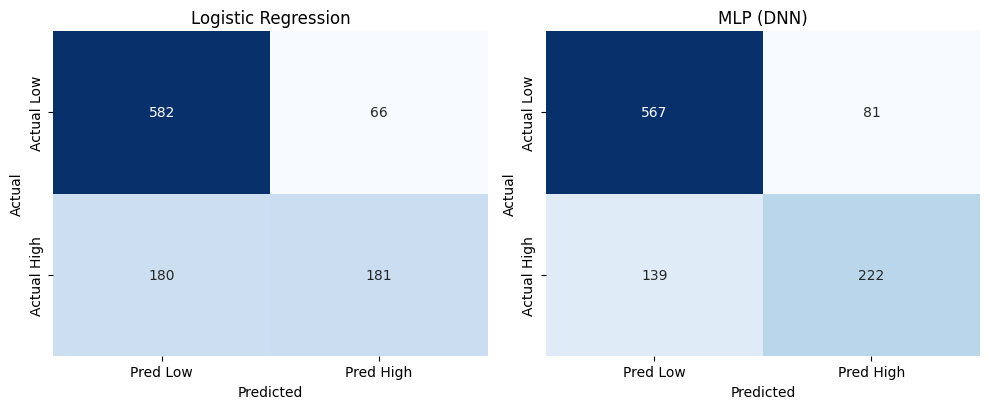

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10,4.2))
for ax, cm, title in zip(axes, [cm_log, cm_mlp_cls], ["Logistic Regression", "MLP (DNN)"]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Low','Pred High'],
                yticklabels=['Actual Low','Actual High'], ax=ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.tight_layout(); plt.show()

The performance comparison between the baseline logistic regression model and the MLP (DNN) classification model shows that the DNN achieved better overall results. The MLP model reached an accuracy of 78.89%, slightly higher than the logistic regression's 75.62%, indicating a small improvement in correctly predicting the overall class labels. Precision was similar between the two models, with logistic regression at 73.28% and MLP at 74.83%, showing that both were equally good at making correct positive predictions. However, the MLP showed a clear improvement in recall, increasing from 50.14% in the logistic regression model to 61.77%, meaning it was better at identifying high-score movies. This improvement in recall also led to a higher F1 score for the MLP (67.68% vs. 59.54%), demonstrating a better balance between precision and recall. Overall, the DNN outperformed the baseline model, particularly in capturing more true positive cases while maintaining competitive precision.

# Hyperparameter Tuning For DNN Classification Model

In [44]:
# Wrap the model
keras_clf = KerasClassifier(
    model=build_model_classification,
    hidden1=64,
    hidden2=32,
    learning_rate=0.001,
    input_dim=X_train_clf.shape[1],
    epochs=50,
    batch_size=32,
    verbose=0
)

# Define hyperparameter grid
param_grid = {
    'hidden1': [32, 64],
    'hidden2': [16, 32],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64],
    'epochs': [30, 50]
}

# Grid search with 5-fold cross-validation
grid = GridSearchCV(estimator=keras_clf, param_grid=param_grid,
                    scoring='f1', cv=5, n_jobs=1)
grid.fit(X_train_clf, y_train_clf)

# Show best params and F1 score
print("Best Parameters:", grid.best_params_)
print(f"Best F1 Score: {grid.best_score_:.4f}")

Best Parameters: {'batch_size': 32, 'epochs': 50, 'hidden1': 32, 'hidden2': 32, 'learning_rate': 0.001}
Best F1 Score: 0.6340


The code wraps the MLP classification model using KerasClassifier so it can be tuned with scikit-learn's GridSearchCV. A grid of possible values for the hidden layer sizes, learning rate, batch size, and number of epochs is defined, and the search is run with 5-fold cross-validation using the F1 score as the evaluation metric. This means every possible combination of hyperparameters in the grid is tested, and the one giving the highest mean F1 score across the folds is selected.

The search found that the best parameters were 32 neurons in the first hidden layer, 32 neurons in the second hidden layer, a learning rate of 0.001, a batch size of 32, and 50 training epochs, achieving a mean cross-validated F1 score of 0.6340. These results suggest that a balanced network size with a standard learning rate, moderate batch size, and sufficient training epochs allowed the model to learn stable patterns, improving the balance between precision and recall compared to other tested configurations.

# Evaluate Best Model with Cross-Validation For DNN Classification Model

In [45]:
# Use best estimator from GridSearchCV
best_clf = grid.best_estimator_

# Perform 5-fold CV with multiple metrics
cv_results = cross_validate(
    best_clf, X_train_clf, y_train_clf, cv=5,
    scoring=['accuracy', 'f1','recall', 'precision'],
    return_train_score=False
)

mean_acc_mlp_tune = cv_results['test_accuracy'].mean()
mean_f1_mlp_tune = cv_results['test_f1'].mean()
mean_recall_mlp_tune = cv_results['test_recall'].mean()
mean_precision_mlp_tune = cv_results['test_precision'].mean()

# Print mean ± std for each metric
print("\n5-Fold Cross-Validation Results:")
print(f"Mean Accuracy: {mean_acc_mlp_tune:.4f}, Std: {cv_results['test_accuracy'].std():.4f}")
print(f"Mean F1 Score: {mean_f1_mlp_tune:.4f}, Std: {cv_results['test_f1'].std():.4f}")
print(f"Mean Recall Score: {mean_recall_mlp_tune:.4f}, Std: {cv_results['test_recall'].std():.4f}")
print(f"Mean Precision Score: {mean_precision_mlp_tune:.4f}, Std: {cv_results['test_precision'].std():.4f}")


5-Fold Cross-Validation Results:
Mean Accuracy: 0.7737, Std: 0.0122
Mean F1 Score: 0.6246, Std: 0.0181
Mean Recall Score: 0.5379, Std: 0.0381
Mean Precision Score: 0.7508, Std: 0.0424


Using the best parameters from tuning (batch_size=32, epochs=50, hidden1=32, hidden2=32, learning_rate=0.001), the model was tested with 5-fold cross-validation to check how well it works on unseen data. The results show a mean accuracy of 77.37% with a small standard deviation of 0.0122, meaning the model gave similar results across different data splits. The mean F1 score was 0.6246 with a standard deviation of 0.0181, showing a good balance between precision and recall. The model had a mean recall of 53.79% and a mean precision of 75.08%, which means it is better at predicting low-score movies but still misses some high-score ones. Overall, the tuned MLP model is stable and works well, but improving recall could make it even better.

# Hyperparameter search map — heatmap from your GridSearchCV


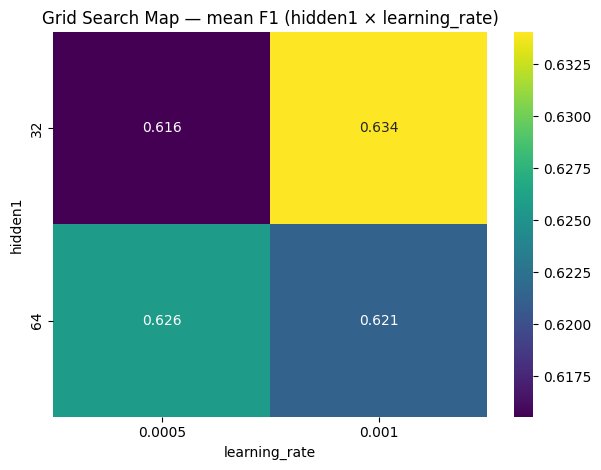

In [46]:
cvres = pd.DataFrame(grid.cv_results_)
# Example: heatmap over hidden1 x learning_rate (filter other params)
sub = cvres[(cvres.param_hidden2==32) & (cvres.param_batch_size==32) & (cvres.param_epochs==50)]
if len(sub) > 0:
    pivot = sub.pivot_table(index='param_hidden1', columns='param_learning_rate',
                            values='mean_test_score', aggfunc='mean')
    plt.figure(figsize=(6.2,4.8))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Grid Search Map — mean F1 (hidden1 × learning_rate)")
    plt.xlabel("learning_rate"); plt.ylabel("hidden1")
    plt.tight_layout(); plt.show()

Observations:
The heatmap shows the mean F1 scores from a grid search that tested combinations of two hyperparameters: the number of neurons in the first hidden layer (hidden1) and the learning rate. The highest F1 score (0.634) occurs when hidden1 = 32 and learning_rate = 0.001, suggesting this combination is the most effective for the classification task in this search. Lower scores are observed when the learning rate is smaller (0.0005) or when hidden1 is set to 64 with a learning rate of 0.001, indicating that both the network size and the learning rate influence model performance, and that smaller networks with a slightly higher learning rate performed better in this case.

# Performance Comparison between DNN models and baseline model For Classification

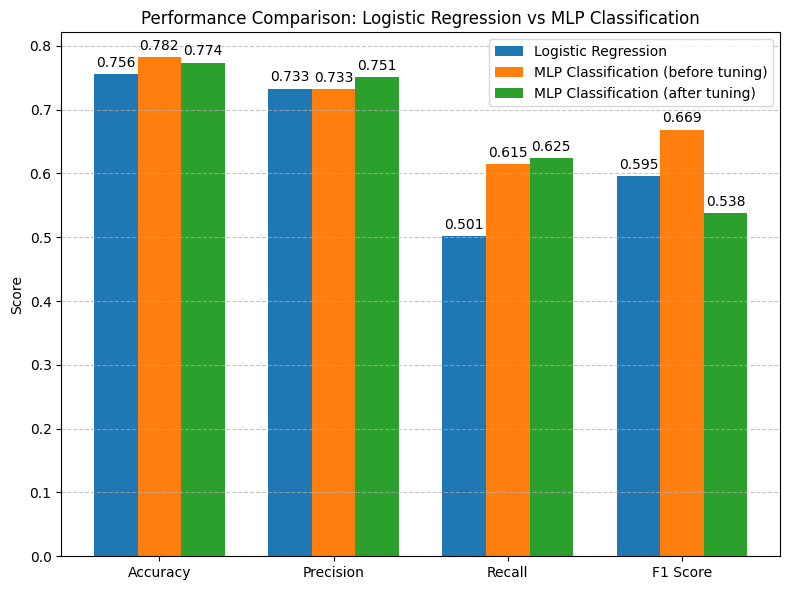

In [47]:
mlp_scores_tune = {mean_acc_mlp_tune, mean_precision_mlp_tune, mean_recall_mlp_tune, mean_f1_mlp_tune}
# Set up bar width
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))  # Metric positions
width = 0.25  # Bar width (adjusted for 3 sets of bars)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create bars for the three models (Logistic Regression, MLP, and Tuned MLP)
bars1 = ax.bar(x - width, lr_scores, width, label='Logistic Regression')
bars2 = ax.bar(x, mlp_scores, width, label='MLP Classification (before tuning)')
bars3 = ax.bar(x + width, mlp_scores_tune, width, label='MLP Classification (after tuning)')

# Add labels and formatting
ax.set_ylabel('Score')
ax.set_title('Performance Comparison: Logistic Regression vs MLP Classification')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

Observations:

The bar chart compares the performance of Logistic Regression, MLP Classification before tuning, and MLP Classification after tuning across four metrics: Accuracy, Precision, Recall, and F1 Score. The results show that both MLP models generally outperform Logistic Regression in accuracy and recall, with the untuned MLP achieving the highest accuracy (0.782) and recall (0.669). Precision is fairly consistent across models, with tuned MLP having a slight edge (0.751). However, in F1 Score, the untuned MLP again leads (0.669), while the tuned MLP’s F1 Score drops to 0.538, indicating that hyperparameter tuning did not improve the balance between precision and recall in this case. This suggests that while tuning improved certain aspects slightly, it may have hurt overall classification balance.